In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade
!pip install --upgrade boto3 botocore s3fs
print('Done running')

Retrieving notices: ...working... done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    jupyter-activity-monitor-extension-0.3.1|     pyhd8ed1ab_1          14 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          14 KB

The following NEW packages will be INSTALLED:

  shap               conda-forge/linux-64::shap-0.46.0-cpu_py311h92109a2_1 
  slicer             conda-forge/noarch::slicer-0.0.8-pyhd8ed1ab_0 

The following packages will be UPDATED:

  amazon-sagemaker-~                     3.1.7-pyhd8ed1ab_0 --> 3.1.8-pyhd8ed1ab_0 
  amazon_sagemaker_~                    0.1.13-pyhd8ed1ab_0 --> 0.1.14-pyhd8ed1ab_0 
  aws-glue-sessions         

In [3]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2025-01-22 01:02:23.550 default:136 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [24]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

# Sanity check
print('region:', region)

region: us-east-2


In [25]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Convert to datetime columns
    df["firstorder"] = pd.to_datetime(df["firstorder"], errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"], errors='coerce')
    # Drop Rows with null values
    df = df.dropna()
    # Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    # Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff'] = (df['created']-df['firstorder']).dt.days
    # Drop Columns
    df.drop(['custid', 'created', 'firstorder', 'lastorder'], axis=1, inplace=True)
    # Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df, prefix=['favday', 'city'], columns=['favday', 'city'])
    return df

In [26]:
default_bucket = "cisco-churn-project-data"
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total.csv")

In [27]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [28]:
def split_datasets(df):
    y = df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train, validation, test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names, train, validation, test

In [29]:
feature_names, train, validation, test = split_datasets(storedata)

In [30]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv", header=False, index=False)

In [31]:
# Hyperparameter Tuning HPO

In [32]:
s3_input_train = TrainingInput(s3_data=f"s3://{default_bucket}/data/train/", content_type="csv")
s3_input_validation = TrainingInput(s3_data=f"s3://{default_bucket}/data/validation/", content_type="csv")

In [33]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [34]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [35]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [36]:
objective_metric_name = "validation:auc"

In [37]:
tuner = HyperparameterTuner(estimator, objective_metric_name, hyperparameter_ranges, max_jobs=10, max_parallel_jobs=2)

In [38]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................!


In [50]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [51]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [52]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2025, 1, 22, 1, 14, 43, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9825819730758667},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2025, 1, 22, 1, 15, 21, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:961341547991:training-job/sagemaker-xgboost-250122-0110-006-aaaf047f',
 'TrainingJobName': 'sagemaker-xgboost-250122-0110-006-aaaf047f',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2025, 1, 22, 1, 14, 47, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.8845003417538022',
                          'eta': '0.07133795174486246',
                          'max_depth': '5',
                          'min_child_weight': '8.62961118089661'}}


In [53]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [54]:
best_hyperparameters

{'alpha': '0.8845003417538022',
 'eta': '0.07133795174486246',
 'max_depth': '5',
 'min_child_weight': '8.62961118089661'}

In [55]:
# 7. XGBoost Model with SageMaker Debugger
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [56]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [57]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [58]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2025-01-22-01-26-31-653


In [59]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [60]:
# 8. Analyze Debugger Output
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:961341547991:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-74f046e7',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 50 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2025, 1, 22, 1, 31, 45, 360000, tzinfo=tzlocal())}]

In [61]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2025-01-22 01:38:02.015 default:136 INFO s3_trial.py:42] Loading trial debug-output at path s3://cisco-churn-project-data/debugger/demo-smdebug-xgboost-churn-classificati-2025-01-22-01-26-31-653/debug-output


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

In [62]:
trial.tensor_names()

[2025-01-22 01:38:14.676 default:136 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-01-22 01:38:15.690 default:136 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [63]:
trial.tensor("average_shap/f1").values()

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

{0: array([0.00070957], dtype=float32),
 5: array([0.00125593], dtype=float32),
 10: array([0.00143539], dtype=float32),
 15: array([0.00164608], dtype=float32),
 20: array([0.005236], dtype=float32),
 25: array([0.01071319], dtype=float32),
 30: array([0.01380956], dtype=float32),
 35: array([0.01796095], dtype=float32),
 40: array([0.02245974], dtype=float32),
 45: array([0.02525828], dtype=float32),
 50: array([0.02630775], dtype=float32),
 55: array([0.03280749], dtype=float32),
 60: array([0.04024345], dtype=float32),
 65: array([0.04866268], dtype=float32),
 70: array([0.05967234], dtype=float32),
 75: array([0.07005714], dtype=float32),
 80: array([0.08008737], dtype=float32),
 85: array([0.09117188], dtype=float32),
 90: array([0.09892716], dtype=float32),
 95: array([0.1036799], dtype=float32)}

In [64]:
MAX_PLOTS = 35

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name

def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

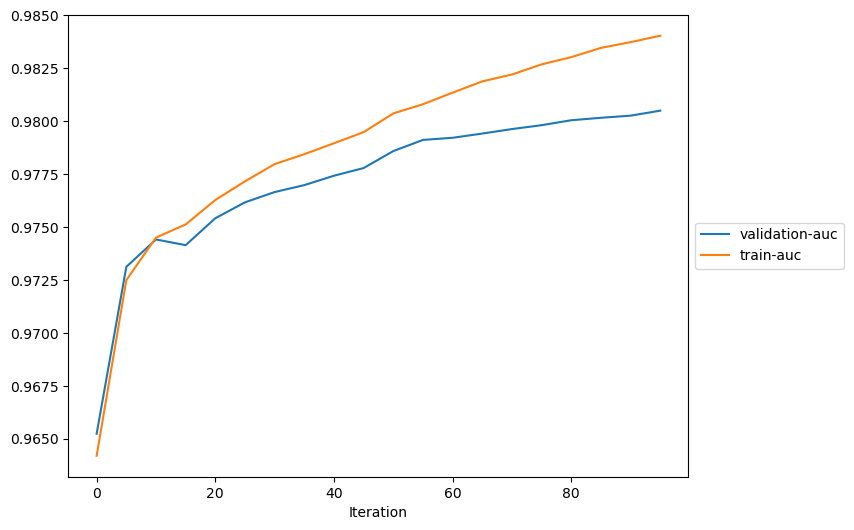

In [46]:
plot_collection(trial, "metrics")

In [47]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

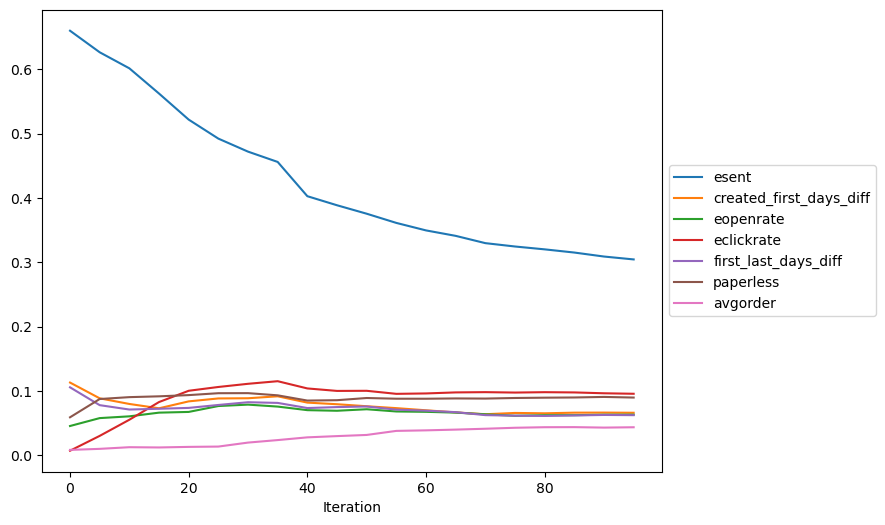

In [48]:
plot_feature_importance(trial, importance_type="cover")

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

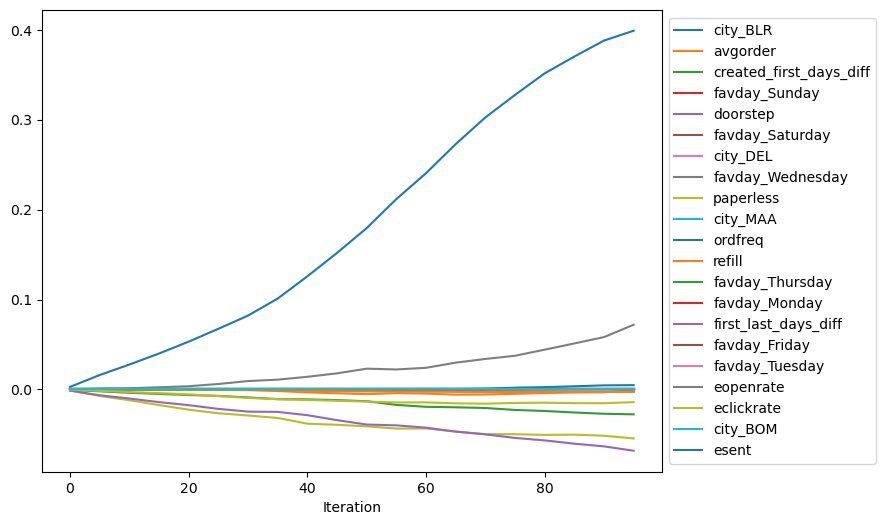

In [49]:
plot_collection(trial, "average_shap")

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


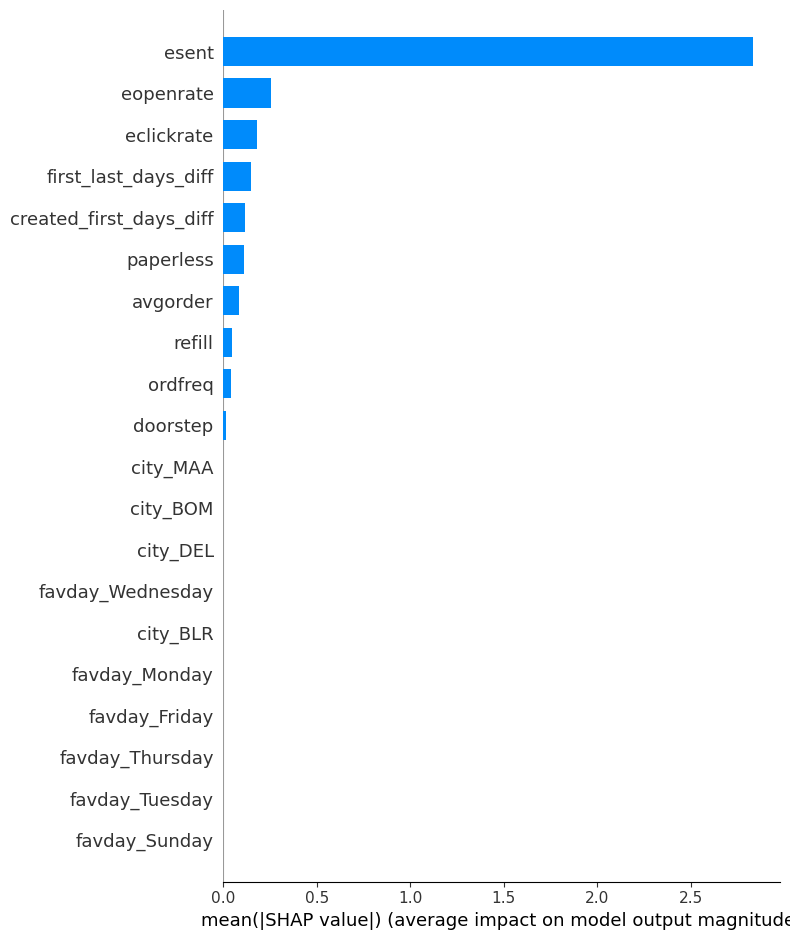

In [50]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [51]:
shap_base_value

2.0088274

In [52]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

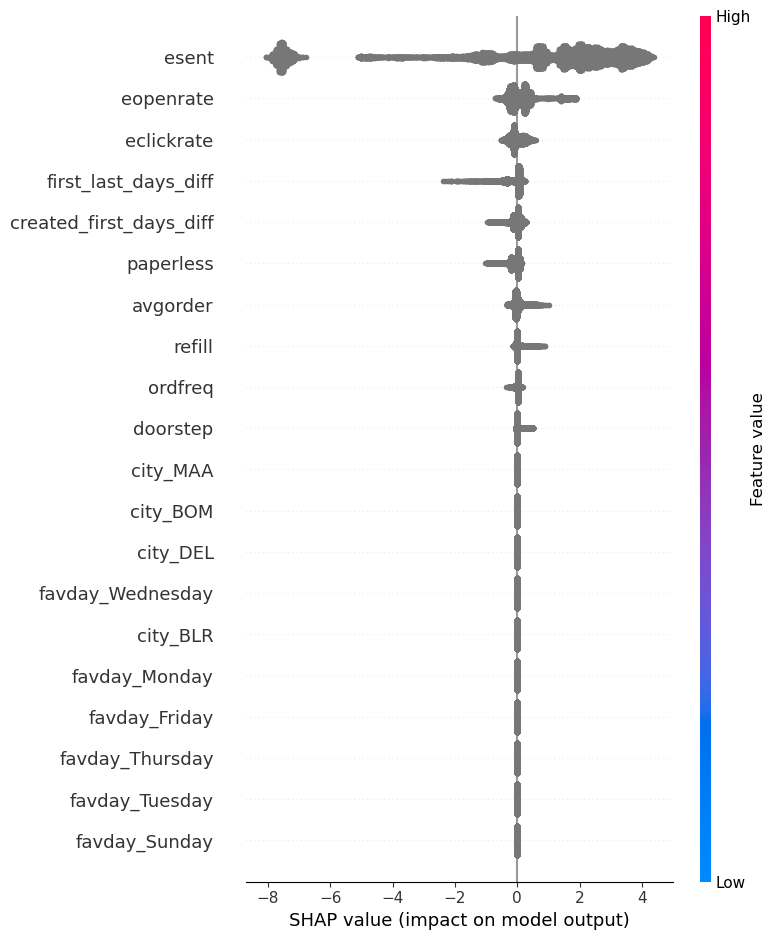

In [53]:
shap.summary_plot(shap_no_base, train_shap)

In [54]:
shap.initjs()

In [55]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [56]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [57]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)